# Bioinformatics 2 Project 1

**Author**: Charles Tapley Hoyt

**Partners**: Aliaksandr Masny


To convert this to a python file:

```sh
pip install jupyter
jupyter nbconvert --to python Project\ 1.ipynb --output Project\ 1.py
```

In [1]:
from collections import defaultdict
import functools
import itertools as itt
import os
import sys
import time

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import seaborn as sns
from sklearn import decomposition

np.random.seed(127)

%matplotlib inline

In [2]:
print(sys.version)

3.5.2 (default, Oct 11 2016, 04:59:56) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.38)]


In [3]:
time.asctime()

'Mon Dec  5 19:08:40 2016'

In [4]:
base = os.environ['NOTEBOOKS']
nbase = os.path.join(base, 'bit', 'bi2')

# Assignment 2

In the first project, we will work with a Chronic Kidney Disease (CKD) Dataset, which contains an experiment on 400 people, 250 of them having CKD and 150 are healthy. In the experiment, on each instance, 24 variables are measured such as age, blood pressure, sugar etc. Note that there are some instances with missing data. For more details on attributes and the experiment read the chronic_kidney_disease.info.txt file.
Please download the chronic_kidney_disease_full.xls file and proceed in the following steps and submit your final script. You will also need its results for the next stage of the project.

## 2A

Read the dataset and print the number of instances and columns, as well as the column names, to the terminal (3P).

In [5]:
df = pd.read_excel('chronic_kidney_disease_full.xls', skipinitialspace=True)
df = df.rename(index=str, columns={"class": "ckd"})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
ckd      400 non-null object
dtypes: float64(14), object(11)
memory usage: 81.2+ KB


## 2B

Write a piece of code to replace nominal attribute values with 0 and 1. For instance, for the “rbc” and “pc” columns, map “normal” to 1 and “abnormal” to 0. For the rest, map “present” to 1 and “notpresent” to 0, “yes” to 1 and “no” to 0, “good” to 1 and “poor” to 0, “ckd” to 1 and “notckd”
to 0 (3P).

In [7]:
d = {
    'pc': 'normal',
    'pcc': 'present',
    'ba': 'present',
    'rbc': 'normal',
    'htn': 'yes',
    'dm': 'yes',
    'cad': 'yes',
    'pe': 'yes',
    'ane':'yes',
    'appet': 'good',
    'ckd': 'ckd'
}

for column, positive in d.items():
    df[column] = pd.get_dummies(df[column])[positive]

## 2C

Interpolate the missing values in a sensible way (2P).

In [8]:
df.interpolate(inplace=True)

In [9]:
df.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      3
pot      3
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
ckd      0
dtype: int64

Because there are null values at the beginning of the lists for the sodium and potassium readouts, they need to be interpolated with a different set of rules.

In [10]:
df.sod = df.sod.interpolate(limit_direction='backward', limit=3)
df.pot = df.pot.interpolate(limit_direction='backward', limit=3)

In [11]:
assert 0 == df.isnull().sum().sum()

## 2D

Extract subgroups with CKD and without CKD and print the number of instances for each subgroup (3P).

In [12]:
diseased_idx, healthy_idx = df.ckd == 1, df.ckd == 0

In [13]:
print(', '.join(a for a, b in diseased_idx.iteritems() if b))

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [14]:
print(', '.join(a for a, b in healthy_idx.iteritems() if b))

250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399


## 2E

The F score is one way to determine how well a given variable distinguishes between two groups. F is large if the differences of the two groups means $x ̄_1$ and $x ̄_2$ to the grand mean $x ̄$ of all data points is large relative to the variances within the groups. Given groups of size $n_1$ and $n_2$ with items $x_{1,i}$ and $x_{2,i}$, respectively, $F$ can be defined as

$F = \frac{(\bar{x}_1 - \bar{x})^2 + (\bar{x}_2 - \bar{x})^2}{\frac{1}{n_1-1}\sum^{n_1}_{i=1} (x_{1,i} - \bar{x}_1)^2 + \frac{1}{n_2-1} \sum^{n_2}_{i=1} (x_{2,i} - \bar{x}_2)^2}$

Define a function that calculates F for any given attribute and for the two CKD and not CKD class labels (8P). Use it to identify the five attributes that best separate the classes CKD vs. not CKD (3P).

In [15]:
def calculate_f(ds, groups):
    """
    :param ds: data set
    :type ds: pd.Series
    :param groups: boolean series to slice data set into 2 groups 
    :type groups: pd.Series
    """
    m = ds.mean()
    g1, g2 = ds[groups], ds[~groups]
    
    num_g1 = np.square(g1.mean() - m)
    num_g2 = np.square(g2.mean() - m)
    
    den_g1 = g1.var()
    den_g2 = g2.var()
        
    return (num_g1 + num_g2) / (den_g1 + den_g2)

In [16]:
f_scores = df.apply(lambda col: calculate_f(col, diseased_idx)).sort_values(ascending=False)
f_scores

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


ckd           inf
hemo     1.740059
pcv      1.464729
sg       1.448556
rbcc     1.170469
rbc      1.085038
al       0.890598
htn      0.755159
dm       0.631237
pc       0.379017
appet    0.240623
sod      0.237424
bu       0.233935
pe       0.231112
su       0.187084
ane      0.167092
sc       0.139003
bp       0.108668
pcc      0.106843
cad      0.083288
wbcc     0.067667
age      0.065529
ba       0.051056
bgr      0.047920
pot      0.005835
dtype: float64

## 2F

Write a reduced dataset to disk. It should only contain the five most relevant attributes from d), and the interpolated replacements of missing values from c) (3P).

In [17]:
# most releveant attribute is obviously the label for CKD or not CKD, 
# so this was included along with the second through 6th most relevant attributes

df_reduced = df[f_scores.index[:6]] 
df_reduced.to_csv('ckd_reduced.tsv', sep='\t')

# Assignment 3

In the previous assignment, you wrote a reduced dataset to disk that is limited to the CKD and notCKD classes and five variables that distinguish most strongly between subjects with and without chronic kidney disease. This week, you will create and interpret a basic visualization of that data.
Your final visualization should be a 5 × 5 matrix whose rows and columns are the measurements of the variables you selected last week. Diagonal cells visualize how the variables are distributed; off-diagonal cells visualize the relationship between the values of pairs of variables.
Please proceed in the following steps and submit your final script, the final image, and answers to the questions:

In [18]:
df_reduced['ckd'] = df_reduced['ckd'].map(lambda x: 'Diseased' if x else 'Healthy')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


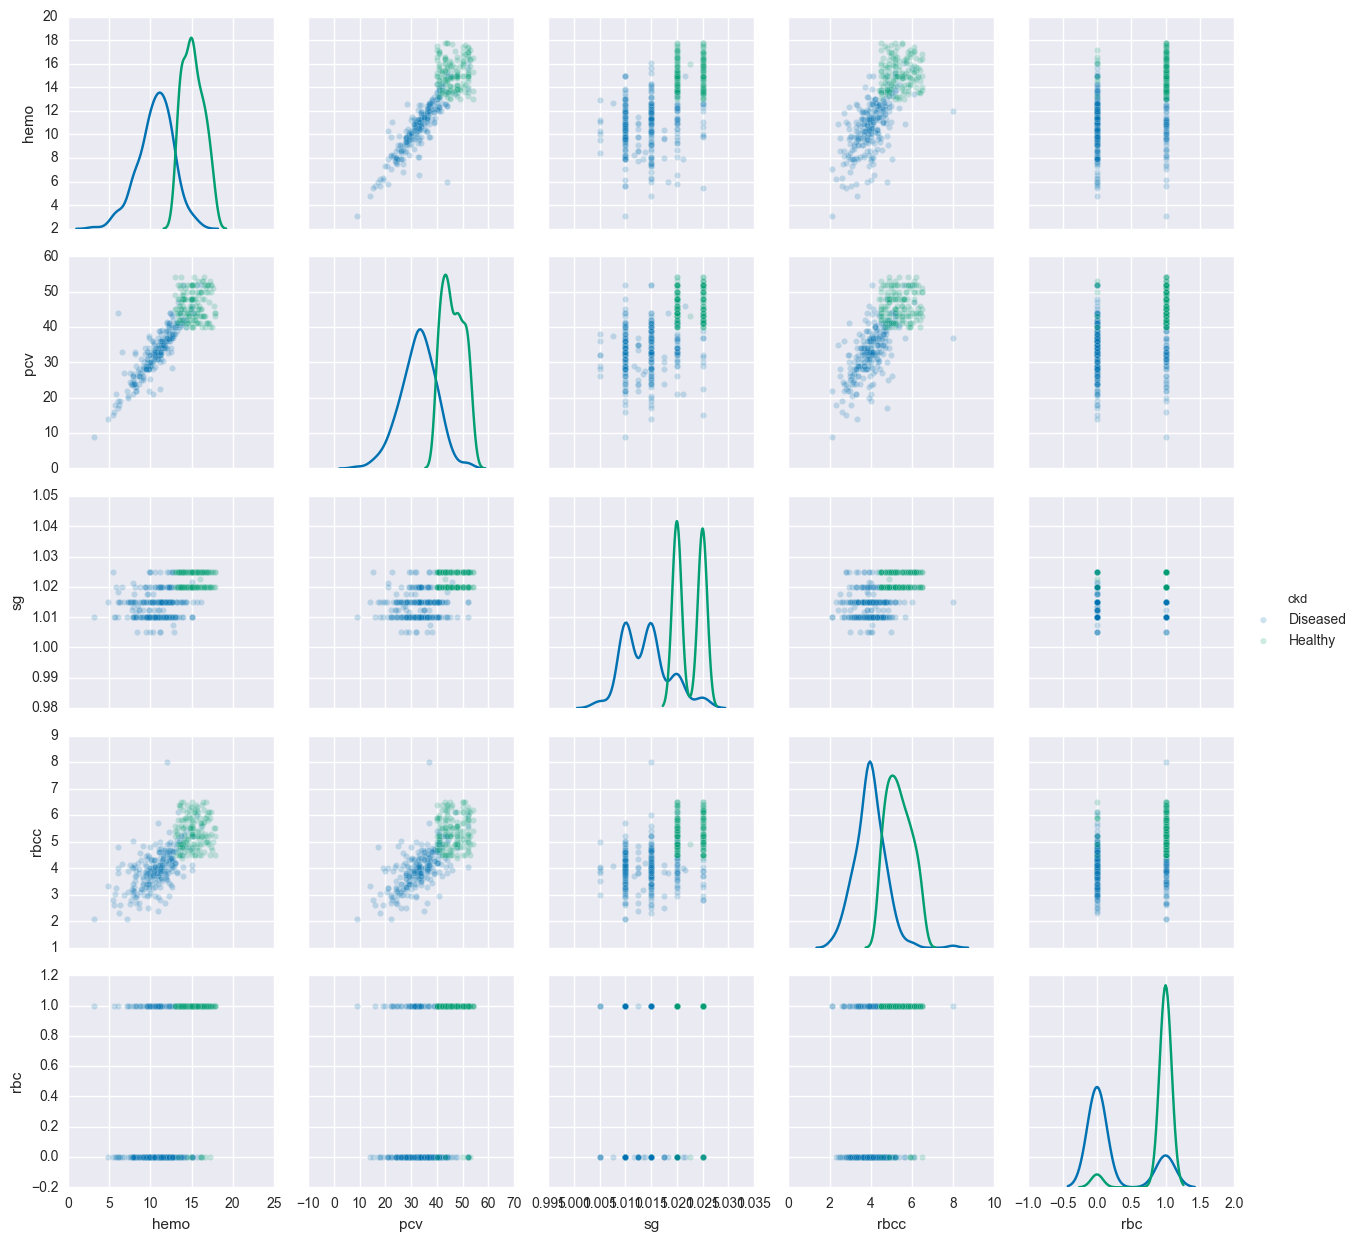

In [19]:
sns.pairplot(df_reduced[1:], hue='ckd', kind='scatter', diag_kind='kde', palette='colorblind', plot_kws={'alpha': 0.2})
plt.show()

## 3A

Each diagonal cell should contain two overlaid density plots, one for the CKD and one for the not CKD class. In the density plot, variable values should be on the x axis, the frequency of observing that value in each class should be on the y axis. Use different colors to distinguish between the classes, and add a legend. Your visual design should make it easy to answer the following questions (5P for implementation, 1P for justifying choice of colors, 3P for answering questions):

- For which variable you could devide the range of the values to three subranges where each indicate either healthy, with CKD or uncertain? Roughly list the subranges.
- Which variable(s) is(are) almost always constant for the healthy subjects?

### 3A Answers

> **Color Choice:** The blue and green color scheme was chosen based on the Seaborn default colorblind accessible palette

> **Disease State Stratification:** The kernel density estimation of red blood cell count (rbcc) show two distinct gaussians that have significant overlap. In the overlapping region, it is difficult to identify healthy or diseased state with this variable only. Outside of the overlapping region, it is obvious to which disease state an individual belongs based on this variable. These ranges roughly correspond to diseased ~ [0, 4], uncertain ~ [4, 5], healthy ~ [5, 8]. The same logic can be applied to hemoglobin (hemo) (diseased ~ [0, 10], uncertain ~ [10, 15], healthy ~ [15, 25]) and packed cell volume (pvc) (diseased ~ [0, 30], uncertain ~ [30, 45], healthy ~ [45, 70])

> **Which variables are constant for healthy subjects:** The kernel density estimate for Hemoglobin (hemo) and packed cell volume (pvc) show two distinct gaussians. They gaussians for each of these variables have very little variance across healthy individuals compared to the large variance across diseased individuals. These variables appear relatively constant compared to the other variables. As a side note, the KDE for red blood cell count (rbcc) also appears as two gaussians, but they are overlapping much more and have similar variance. It's more difficult to assess specific gravity (sg) and red blood cell (rbc) because these values are more quantized, over a smaller range, do not have gaussian distributions, and have smaller difference in variance between diseased and healthy individuals.

## 3B

b) In each non-diagonal cell, display a scatter plot that visualizes the values of the corresponding pair of variables. Use different colors, opacities and markers so that it is simple to relate these scatter plots to the density plots on the diagonal, and the size of the marker reflects the number of overlapping points. (5P for implementation, 2P for answering questions):

- Point out a pair of variables whose values have a clear positive correlation overall.
- Can you identify a pair of variables for which the values are highly correlated in one group of subjects (e.g. healthy), but less so in the other group?

### 3B Answers

> **Pairs of correlated variables:** (hemo, rbcc), (hemo, pvc), and (pvc, rbcc) are overall mutually positively correlated.

> **Correlation within subgroups**: For the pair (hemo, pvc), the diseased subgroup shows a strong positive correlation, but the healthy subgroup does not show correlation. This also occurs to a lesser extent in the other correlated pairs (rbcc, hemo), (rbcc, pcv).

## 3C

c) Compute the distance consistency of all scatter plots. Which pair of variables leads to the highest distance consistency? (6P)

For each scatter plot:
1. calculate centroids for each class
2. calculate the distance from each point to each centroid
3. decide if properly labeled
4. count improperly labeled / number of classes

In [20]:
dsc_dict = defaultdict(int)

for a, b in itt.combinations(df_reduced.columns[1:], 2):
    
    healthy_centroid  = df_reduced.loc[healthy_idx,  a].mean(), df_reduced.loc[healthy_idx,  b].mean()
    diseased_centroid = df_reduced.loc[diseased_idx, a].mean(), df_reduced.loc[diseased_idx, b].mean()
    
    for idx, cls, av, bv in df_reduced[['ckd', a, b]].itertuples():
        healthy_d  = euclidean(healthy_centroid,  (av, bv))
        diseased_d = euclidean(diseased_centroid, (av, bv))
        
        if (cls == 'Diseased' and diseased_d < healthy_d) or (cls == 'Healthy' and healthy_d < diseased_d):
            dsc_dict[a, b] += 1
      
    dsc_dict[a, b] = 100 * dsc_dict[a, b] / len(df_reduced.index)

In [21]:
dsc_df = pd.DataFrame([(a, b, v) for (a, b), v in dsc_dict.items()], columns=['Variable A','Variable B', 'Distance Consistiency'])
dsc_df.sort_values('Distance Consistiency', ascending=False)

,Variable A,Variable B,Distance Consistiency
0,hemo,rbcc,93.00
8,rbcc,rbc,93.00
2,hemo,rbc,92.75
4,hemo,sg,92.50
1,pcv,rbc,89.25
5,pcv,sg,89.25
7,hemo,pcv,89.25
9,pcv,rbcc,89.25
6,sg,rbcc,86.00
3,sg,rbc,82.75


## 3D

Imagine that, given only the values of two variables, you will be asked to decide whether they are from a healthy subject, or a person with chronic kidney disease. Which pair of variables would you choose to make that decision? Modify the visualization to best answer the question, and justify both your answer and your modification. (3P)

### 3D Answer

> The pair of hemoglobin and red blood cell count consistiently had the best performance with the f-score calculation, distance constiency, and by visual inspection. I would have the highest confidence in using these variables to stratify a patient. The plot was modified to show the 2D kernel density estimate instead of the scatter plot to better describe the underlying distribution and better quantify the overlapping region. This would be the best visual tool to use two plots to stratify new data, keeping in mind that there are no variable pairs that make the data seperable, and the overlap between healthy and diseased patients with these variables is the best we can do.


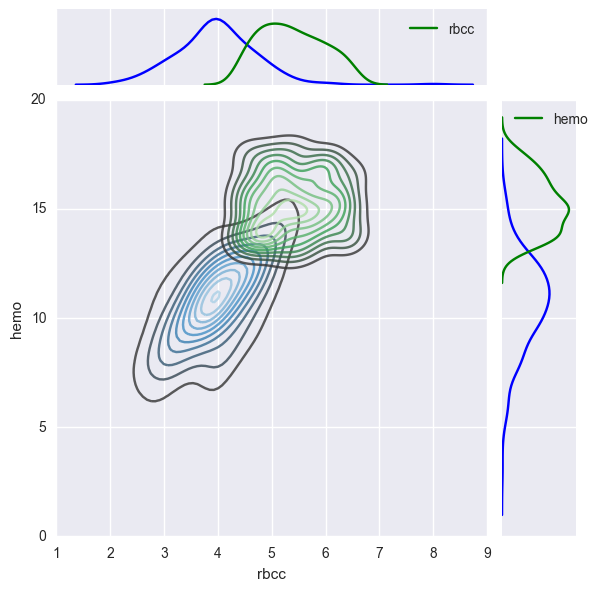

In [22]:
x, y = 'rbcc', 'hemo'

g = sns.JointGrid(df_reduced.loc[diseased_idx, x], df_reduced.loc[diseased_idx, y])
g = g.plot_joint(sns.kdeplot, cmap="Blues_d", alpha=0.8)
g.plot_marginals(sns.kdeplot, color="b")

g.x, g.y = df_reduced.loc[healthy_idx, x], df_reduced.loc[healthy_idx, y]
g.plot_joint(sns.kdeplot, cmap="Greens_d", alpha=0.8)
g.plot_marginals(sns.kdeplot, color="g")

plt.show()

# Assignment 4

It is difficult to fully visualize a very high-dimensional space. In the previous two assignments, we therefore focused on a few variables that we found to be particularly discriminative. This week, we will instead employ dimensionality reduction on the values of all variables.

## 4A

Perform a Principal Component Analysis (PCA) on the values.
Please download the new chronic_kidney_disease_full.xls file, which is uploaded with this exercise sheet. Interpolate missing values, and keep all variables this time. Make a plot that, for any number n, shows what fraction of the overall variance in the data is contained in the first n principal components. How many components do we need to cover ≥ 99.99% of the variance? (5P)
Hint: You may use the implementation of PCA that is provided in the Python package scikit-learn.

In [23]:
pca1 = decomposition.PCA()
pca1.fit(df[[c for c in df.columns if c != 'ckd']])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

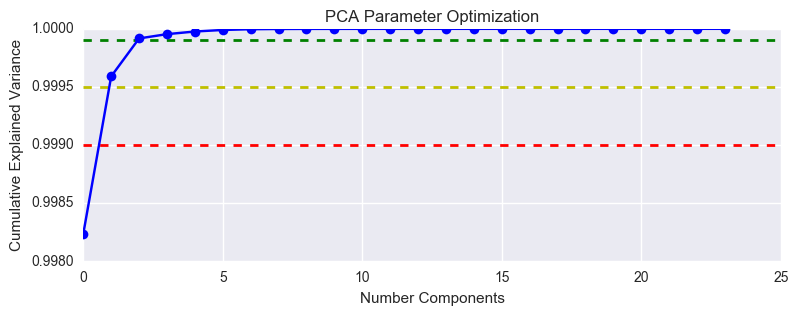

In [24]:
plt.figure(figsize=(9, 3))

plt.title("PCA Parameter Optimization")
plt.xlabel("Number Components")
plt.ylabel("Cumulative Explained Variance")

plt.axhline(0.9990, color='r', linestyle='--', linewidth=2)
plt.axhline(0.9995, color='y', linestyle='--', linewidth=2)
plt.axhline(0.9999, color='g', linestyle='--', linewidth=2)
plt.plot(np.cumsum(pca1.explained_variance_ratio_), 'bo-')
plt.ylim(0.998, 1)

plt.show()

### 4A Answer

> Only 2 principle components are necessary to explain > 99.99% of the variance. This is because many of these clinical variables are highly correlated overall. However, as we've seen, the correlation might not be as strong within the subgroups.

## 4B

Each sample is now characterized by a point in PCA space. Create a scatter plot matrix (in the same manner as in the previous sheet) that shows the first five principal components. In which PCA modes do you see a clear difference between the healthy subjects and the people with CKD, in which modes the difference is less? (4P)

In [25]:
pca2 = decomposition.PCA(n_components=5)
df_pca = pd.DataFrame(pca2.fit_transform(df[[c for c in df.columns if c != 'ckd']]))
df_pca['ckd'] = list(df_reduced['ckd'])
df_pca.head()

,0,1,2,3,4,ckd
0,-688.975353,-34.847969,-18.047751,-0.961620,7.454630,Diseased
1,-2488.696071,117.640716,-44.981873,47.279337,-6.235005,Diseased
2,-988.301334,268.694508,-13.201555,-5.712028,3.910306,Diseased
3,-1788.954743,-35.459402,3.804491,1.506988,-1.067405,Diseased
4,-1189.007163,-49.115734,-26.389325,-6.146526,6.802697,Diseased


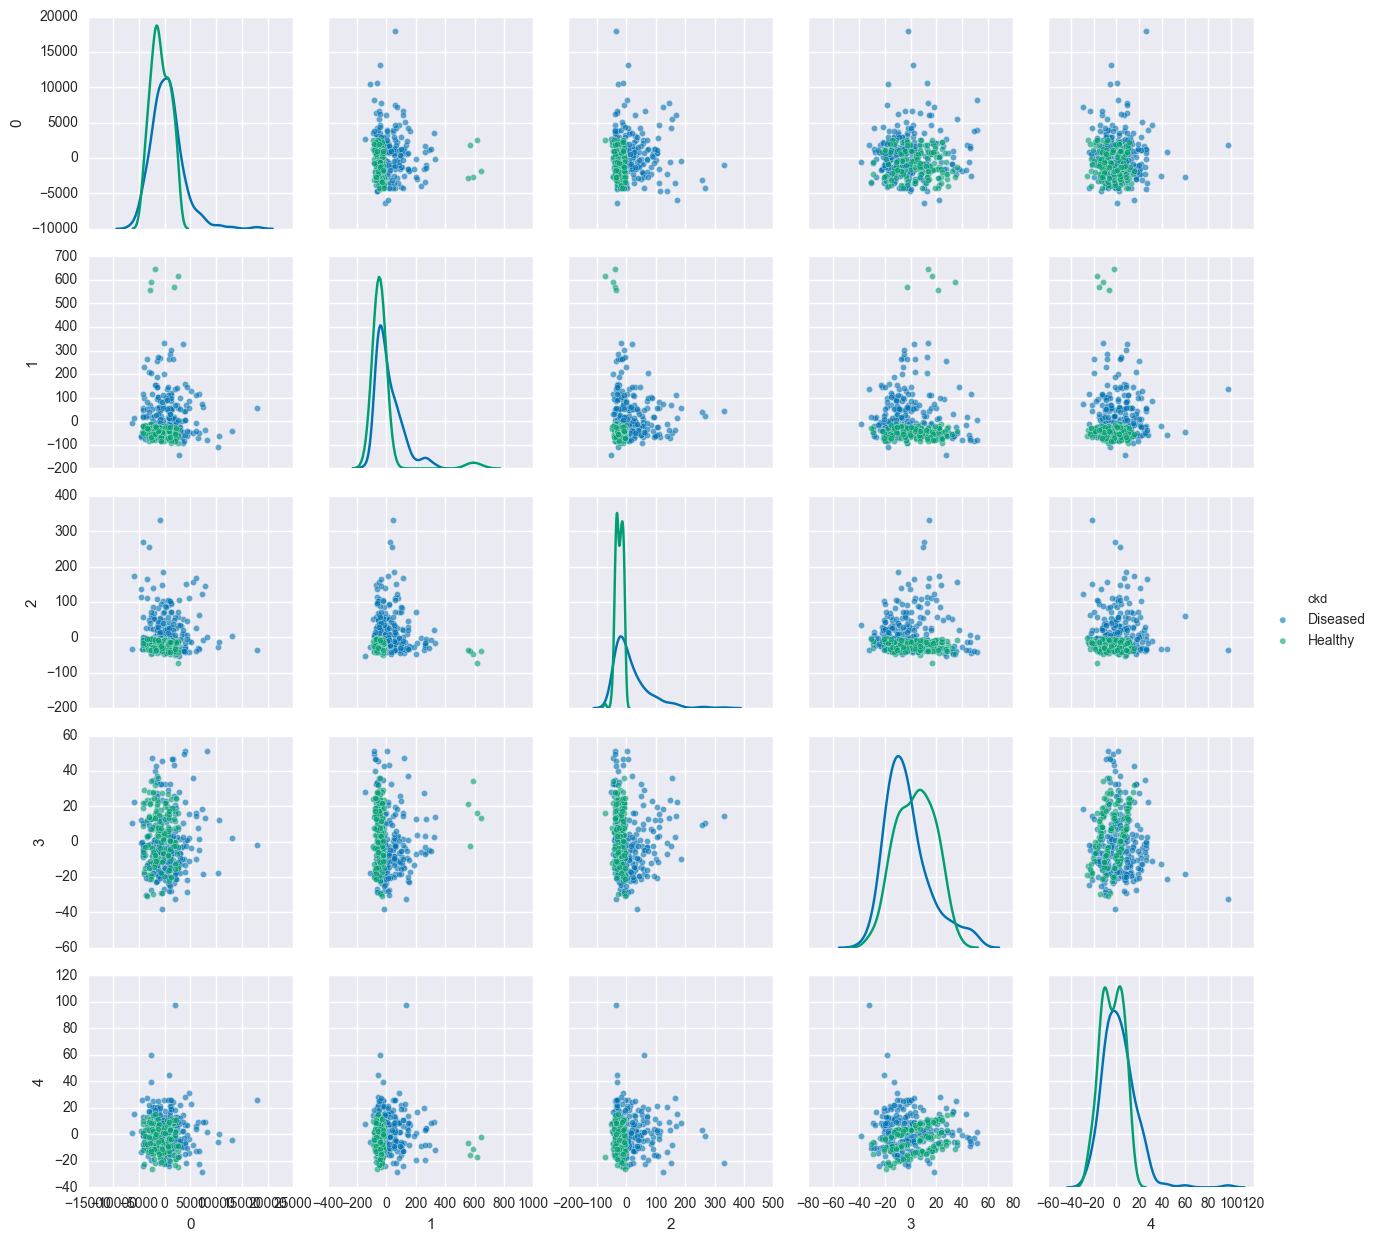

In [26]:
sns.pairplot(df_pca, hue='ckd', kind='scatter', diag_kind='kde', palette='colorblind', plot_kws={'alpha': 0.6})
plt.show()

### 4A Answer

> In the top 3 components, there are regions that are clearly diseased, but in the other regions it is generally difficult to determine with an individual component whether an individual is healthy or diseased. The fourth and fifth modes show little to no difference between healthy and diseased individuals. However, at this point, there may be bias in the PCA due to the different number of healthy and diseased individuals in the source sample.

## 4C
In the second PCA mode, you should see a clear cluster of outliers, a group of points that belong together, but are quite far away from the rest of the data. Provide a list of all subject-IDs that form that cluster and then remove the outliers. Use the index of subject’s row as the subject-ID. (5P)

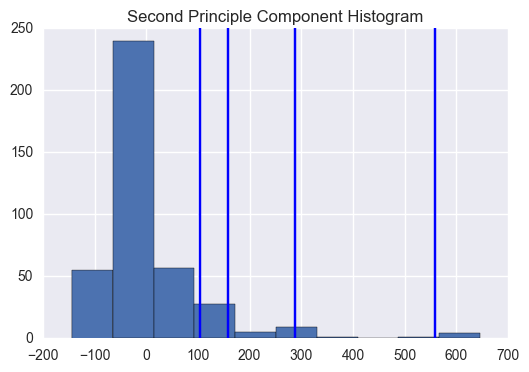

In [27]:
plt.title('Second Principle Component Histogram')
plt.hist(df_pca[1])

for x in np.percentile(df_pca[1], [90, 95, 98, 99]):
    plt.axvline(x)
plt.show()

In [28]:
not_outliers = df_pca[1] < np.percentile(df_pca[1], 98.8)

In [29]:
outlier_indexes = [index for index, value in not_outliers.iteritems() if not value]
outlier_indexes

[360, 369, 384, 386, 395]

In [30]:
df_pca_sliced = df_pca[not_outliers]

## 4D
The results of our Principal Component Analysis are more strongly affected by changes in the values of variables that are very large overall than by others with lower overall values. Account for this by computing the mean value for each variable. Then, replace each value with a factor that describes its deviation from the respective average. To do so, normalize the values of each variable between 0 and 1, then subtract the average from all the values of that variable. Observe how this affects the PCA. How does the number of components needed to cover ≥ 99.99% of the variance change? (4P)

In [31]:
df_means = df.mean()
df_norm = pd.DataFrame({col: (df[col] - df[col].min()) / (df[col].max() - df[col].min()) for col in df.columns if col != 'ckd'})

df_norm.head()

,age,al,ane,appet,ba,bgr,bp,bu,cad,dm,...,pcv,pe,pot,rbc,rbcc,sc,sg,sod,su,wbcc
0,0.522727,0.2,0.0,1.0,0.0,0.127249,0.230769,0.088575,0.0,1.0,...,0.777778,0.0,0.000000,0.0,0.525424,0.010582,0.75,0.671924,0.0,0.231405
1,0.056818,0.8,0.0,1.0,0.0,0.321337,0.000000,0.042362,0.0,0.0,...,0.644444,0.0,0.000000,0.0,0.451977,0.005291,0.75,0.671924,0.0,0.157025
2,0.681818,0.4,1.0,0.0,0.0,0.515424,0.230769,0.132221,0.0,1.0,...,0.488889,0.0,0.000000,1.0,0.378531,0.018519,0.25,0.671924,0.6,0.219008
3,0.522727,0.8,1.0,0.0,0.0,0.122108,0.153846,0.139923,0.0,0.0,...,0.511111,1.0,0.000000,1.0,0.305085,0.044974,0.00,0.671924,0.0,0.185950
4,0.556818,0.4,0.0,1.0,0.0,0.107969,0.230769,0.062901,0.0,0.0,...,0.577778,0.0,0.007865,1.0,0.423729,0.013228,0.25,0.769716,0.0,0.210744


In [32]:
pca3 = decomposition.PCA()
pca3.fit(df_norm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

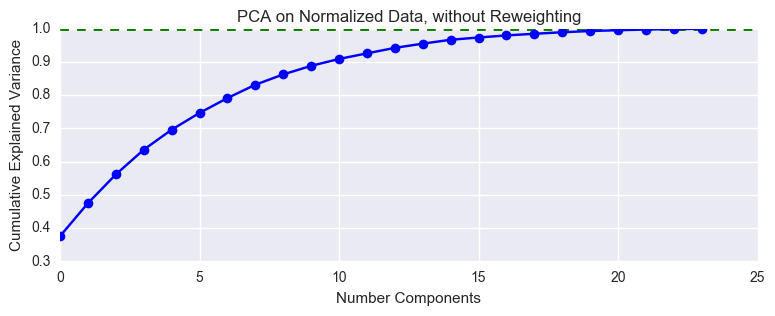

In [33]:
plt.figure(figsize=(9, 3))

plt.title("PCA on Normalized Data, without Reweighting")
plt.xlabel("Number Components")
plt.ylabel("Cumulative Explained Variance")

plt.axhline(0.9990, color='r', linestyle='--', linewidth=2)
plt.axhline(0.9995, color='y', linestyle='--', linewidth=2)
plt.axhline(0.9999, color='g', linestyle='--', linewidth=2)
plt.plot(np.cumsum(pca3.explained_variance_ratio_), 'bo-')

plt.show()

## 4E
See what happens when we re-weight the variables to emphasize those that discriminate well between classes CKD and not CKD. To do so, first normalize as in d), then compute F scores (cf. sheet 2, task 1 e)) and multiply each data value by its corresponding F score. Create two scatter plots to compare PCA results with and without the re-weighting. (4P)

In [34]:
f_scores = df_norm.apply(lambda col: calculate_f(col, diseased_idx)).sort_values(ascending=False)
f_scores

hemo     1.740059
pcv      1.464729
sg       1.448556
rbcc     1.170469
rbc      1.085038
al       0.890598
htn      0.755159
dm       0.631237
pc       0.379017
appet    0.240623
sod      0.237424
bu       0.233935
pe       0.231112
su       0.187084
ane      0.167092
sc       0.139003
bp       0.108668
pcc      0.106843
cad      0.083288
wbcc     0.067667
age      0.065529
ba       0.051056
bgr      0.047920
pot      0.005835
dtype: float64

In [35]:
df_norm_scaled = pd.DataFrame({col: df_norm[col] * f_scores[col] for col in df_norm.columns})
df_norm_scaled.head()

,age,al,ane,appet,ba,bgr,bp,bu,cad,dm,...,pcv,pe,pot,rbc,rbcc,sc,sg,sod,su,wbcc
0,0.034254,0.178120,0.000000,0.240623,0.0,0.006098,0.025077,0.020721,0.0,0.631237,...,1.139234,0.000000,0.000000,0.000000,0.614992,0.001471,1.086417,0.159531,0.00000,0.015658
1,0.003723,0.712478,0.000000,0.240623,0.0,0.015398,0.000000,0.009910,0.0,0.000000,...,0.943936,0.000000,0.000000,0.000000,0.529026,0.000735,1.086417,0.159531,0.00000,0.010625
2,0.044679,0.356239,0.167092,0.000000,0.0,0.024699,0.025077,0.030931,0.0,0.631237,...,0.716090,0.000000,0.000000,1.085038,0.443059,0.002574,0.362139,0.159531,0.11225,0.014820
3,0.034254,0.712478,0.167092,0.000000,0.0,0.005851,0.016718,0.032733,0.0,0.000000,...,0.748639,0.231112,0.000000,1.085038,0.357092,0.006251,0.000000,0.159531,0.00000,0.012583
4,0.036488,0.356239,0.000000,0.240623,0.0,0.005174,0.025077,0.014715,0.0,0.000000,...,0.846288,0.000000,0.000046,1.085038,0.495961,0.001839,0.362139,0.182749,0.00000,0.014260


In [36]:
pca4 = decomposition.PCA()
df_norm_scaled_pca = pca4.fit_transform(df_norm_scaled)

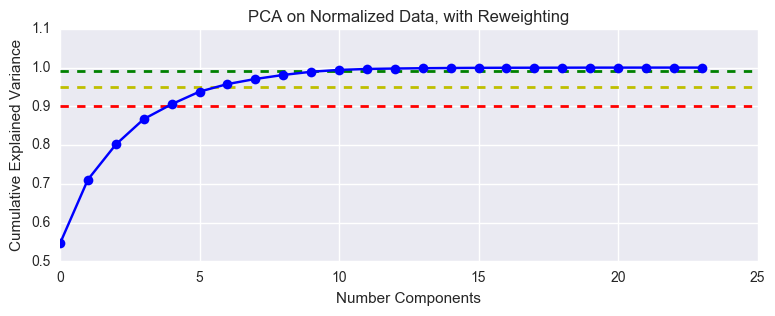

In [37]:
plt.figure(figsize=(9, 3))

plt.title("PCA on Normalized Data, with Reweighting")
plt.xlabel("Number Components")
plt.ylabel("Cumulative Explained Variance")

plt.axhline(0.90, color='r', linestyle='--', linewidth=2)
plt.axhline(0.95, color='y', linestyle='--', linewidth=2)
plt.axhline(0.99, color='g', linestyle='--', linewidth=2)
plt.plot(np.cumsum(pca4.explained_variance_ratio_), 'bo-')

plt.show()

### 4E Comment

> After reweighting, the scree plot looks much more reasonable, with about 5 components being necessary to explain 95% of the variance. However, we've induced this variance explicitly, and this is not necessarily meaningful.

## 4F

By using the PCA plot from task e), could you say whether using the average value of each variable for interpolating the missing values of that variable is a good way of interpolation? (3P)

### 4F Answer

> No, this is not a good way of interpolation, becuase it can disproportionately affect normalization and feature scaling methods that are necessary to investigate the inner structure of the data with PCA and other unsupervised learning methods. In 4E, we observed these artifacts disguised as real results.

# Assignment 5

In the final part of the first project, you will learn how to use the graph visualization package Graphviz
via its Python bindings.

## 5A

Compute the correlation between all the variables. Using your data set, write down a code to fill in the missing values and then compute the pairwise Pearson correlation between variables in a matrix. (5P)

In [38]:
df_corr = np.abs(df.corr())

## 5B

Install the Graphviz library and its Python interface. Generate and visualize some simple graph. You can find the software and its documentation at https://pypi.python.org/pypi/graphviz. (5P)

> A better solution is NetworkX, a pure-python network data structure and analytics package. It has support for using graphviz layouts.

## 5C

Create a graph from the correlation matrix and visualize it. Represent each variable as a node in the graph. Insert an edge between two variables whenever the Pearson correlation between them exceeds the threshold ⇢ > 0.5. (4P)

In [39]:
graph = nx.from_numpy_matrix(df_corr.as_matrix())
graph = nx.relabel_nodes(graph, dict(enumerate(df.columns)))

for u in graph.nodes():
    graph.remove_edge(u, u)

graph.number_of_nodes(), graph.number_of_edges()

(25, 300)

In [40]:
cut_graph = nx.Graph()

for u, v, data in graph.edges_iter(data=True):
    if data['weight'] >= 0.5 and u != v:
        cut_graph.add_edge(u, v, weight=data['weight'])

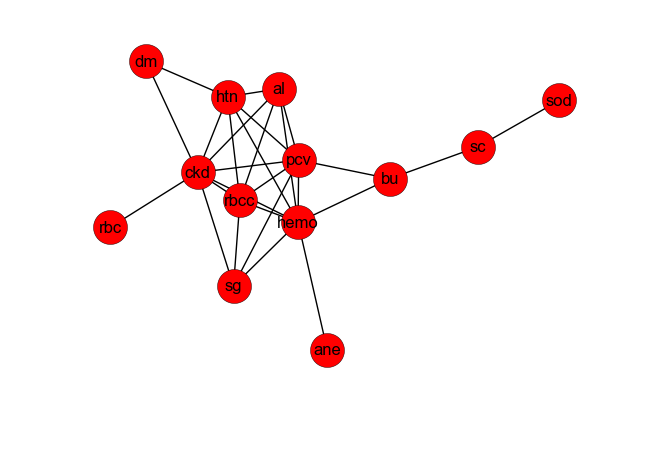

In [41]:
pos = graphviz_layout(cut_graph)

nx.draw(cut_graph, pos=pos, node_size=600, width=1, with_labels=True)

## 5D

Modify the visual attributes of edges to reflect the magnitude of the correlation. (3P)

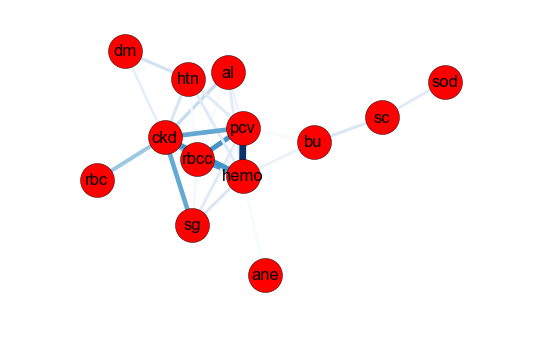

In [42]:
plt.axis('off')

nx.draw_networkx_nodes(cut_graph, pos, node_size=600)

edges = cut_graph.edges()
weights = [(2.5 * cut_graph.edge[u][v]['weight']) ** 2 for u, v, in edges]

nx.draw_networkx_edges(cut_graph, pos, edgelist=edges, width=weights, edge_color=weights, edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(cut_graph, pos)
plt.show()

## 5E

Produce an alternative visualization in which there are three subgraphs, one containing all the nodes that have at least one correlation more than 0.65 to other nodes, another subgraph for nodes with 0.5 < ⇢max <= 0.65 and the last subgraph for the remaining nodes. The “class” node should be outside of all subgraphs. (5P)

In [43]:
group_a, group_b, group_c = set(), set(), set()
for u, v, d in graph.edges_iter(data=True):
    if d['weight'] >= 0.65:
        group_a.add(u)
        group_a.add(v)
    elif d['weight'] >= 0.5:
        group_b.add(u)
        group_b.add(v)
    else:
        group_c.add(u)
        group_c.add(v)
        
group_c = group_c - group_b
group_b = group_b - group_a

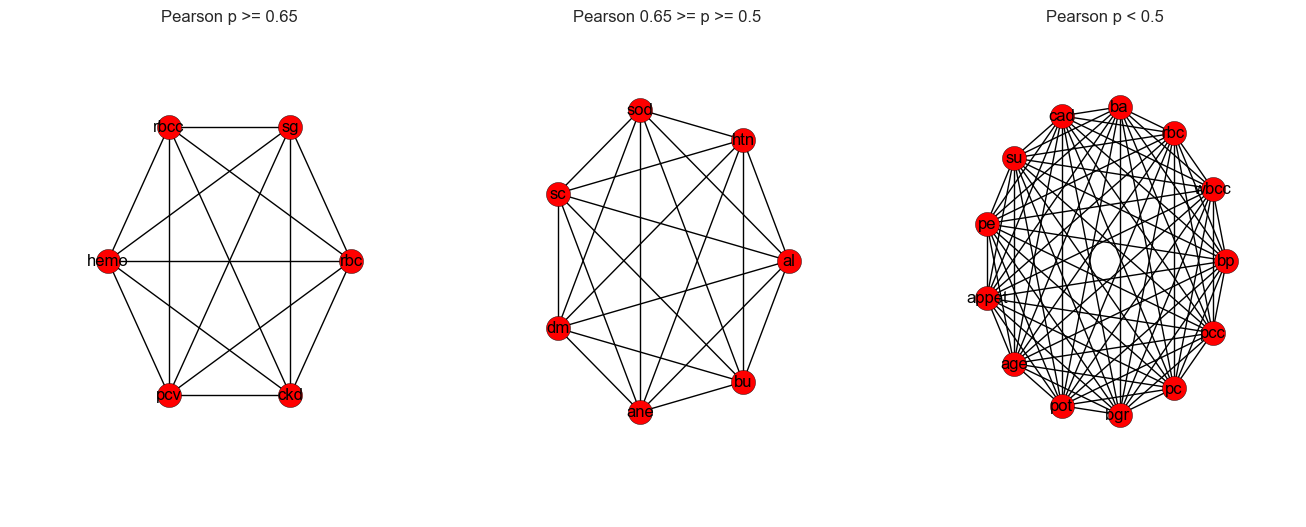

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].set_title('Pearson p >= 0.65')
nx.draw_circular(graph.subgraph(group_a), ax=axes[0], with_labels=True)

axes[1].set_title('Pearson 0.65 >= p >= 0.5')
nx.draw_circular(graph.subgraph(group_b), ax=axes[1], with_labels=True)

axes[2].set_title('Pearson p < 0.5')
nx.draw_circular(graph.subgraph(group_c), ax=axes[2], with_labels=True)

## 5F

Answer the following questions:
- At the selected threshold, which nodes are disconnected from the rest of the graph and what do they indicate? (1P)
- If two nodes A and B are strongly correlated, and node C is strongly correlated with node B, can we conclude that node C will be also strongly correlated with node A? (1P)
- Where have you already seen most of the nodes in the subgraph with ⇢ > 0.65? (1P)

### 5F Answer

> At a selected threshold, disconnected nodes are uncorrelated to any of the other nodes displayed. This could be useful to identify novel features.

> If two nodes are strongly correlated, then we cannot necessarily assume there is a strong correlation between their partners. This is exeplified above by the fact that correlation graphs are not fully connected graphs. However, we do observe the opposite phenomena when isolating nodes that only have thresholds in certain ranges.

> The nodes that are correlated above 0.65 represent the variables that were found to have high F-scores.